### Dataset: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset?resource=download
### Tutorial: https://www.youtube.com/watch?v=V_xro1bcAuA&t=77134s

In [1439]:
!pip install tqdm
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1440]:
import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Tuple, Dict, List
import random
import os
torch.__version__

'2.2.1+cu121'

In [1441]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [1442]:
!nvidia-smi

Sat Mar 16 16:43:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.60.01              Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 36%   41C    P8             32W /  400W |    3125MiB /  12288MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1443]:
IMAGE_PATH = "./data/melanoma"

In [1444]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filesnames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filesnames)} images in '{dirpath}'")

walk_through_dir("./data")

There are 1 directories and 0 images in './data'
There are 2 directories and 0 images in './data/melanoma'
There are 2 directories and 0 images in './data/melanoma/train'
There are 0 directories and 100 images in './data/melanoma/train/Benign'
There are 0 directories and 100 images in './data/melanoma/train/Malignant'
There are 2 directories and 0 images in './data/melanoma/test'
There are 0 directories and 100 images in './data/melanoma/test/Benign'
There are 0 directories and 100 images in './data/melanoma/test/Malignant'


In [1445]:
image_dir = Path("./data/melanoma")
train_dir = Path("./data/melanoma/train")
test_dir = Path("./data/melanoma/test")

Random image path: data/melanoma/test/Benign/7106.jpg
Image class is: Benign
Image width: 224
Image height: 224


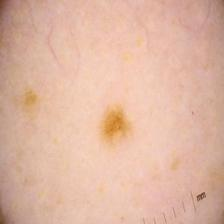

In [1446]:
image_path_list = list(image_dir.glob("*/*/*.jpg"))
rand_image_path = random.choice(image_path_list)
image_class = rand_image_path.parent.stem
img = Image.open(rand_image_path)
print(f"Random image path: {rand_image_path}")
print(f"Image class is: {image_class}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")
img

(-0.5, 223.5, 223.5, -0.5)

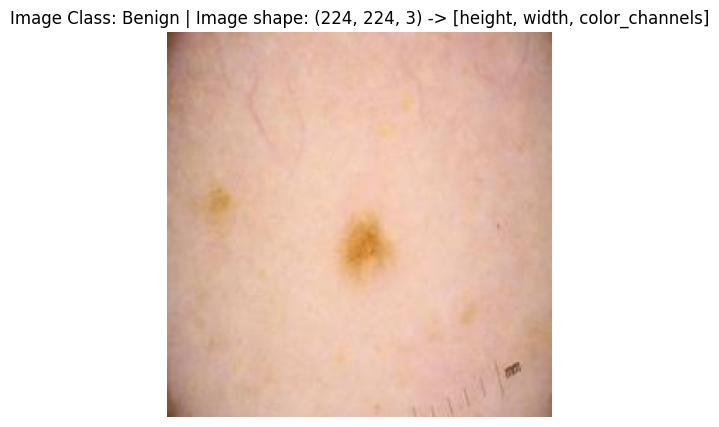

In [1447]:
img_as_array = np.asarray(img)

plt.figure(figsize=(5,5))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [1448]:
img_as_array

array([[[105,  60,  39],
        [109,  64,  43],
        [115,  70,  51],
        ...,
        [152, 113,  96],
        [141, 102,  85],
        [133,  94,  77]],

       [[107,  62,  41],
        [111,  66,  45],
        [117,  72,  53],
        ...,
        [152, 113,  96],
        [144, 105,  88],
        [138,  99,  82]],

       [[110,  65,  44],
        [114,  69,  48],
        [120,  75,  56],
        ...,
        [153, 114,  97],
        [148, 109,  92],
        [144, 105,  88]],

       ...,

       [[112,  77,  49],
        [113,  78,  50],
        [115,  79,  53],
        ...,
        [156, 119, 100],
        [150, 113,  94],
        [147, 111,  89]],

       [[105,  70,  40],
        [107,  72,  44],
        [111,  75,  49],
        ...,
        [156, 119, 100],
        [150, 113,  94],
        [145, 109,  87]],

       [[101,  66,  36],
        [104,  69,  39],
        [109,  73,  47],
        ...,
        [157, 120, 101],
        [149, 112,  93],
        [144, 108,  86]]

In [1449]:
data_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [1450]:
data_transform(img).shape

torch.Size([3, 128, 128])

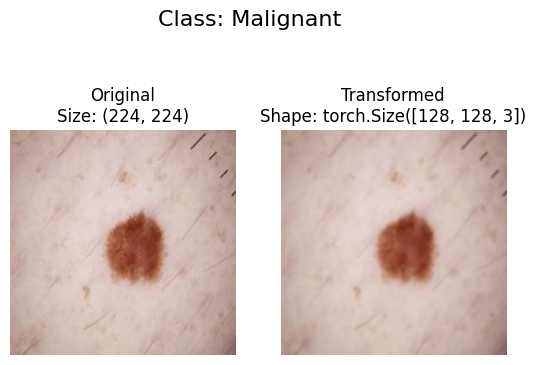

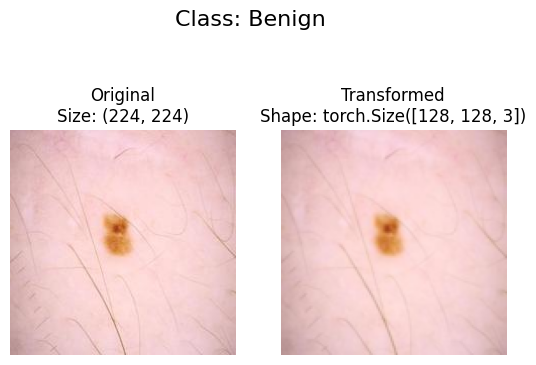

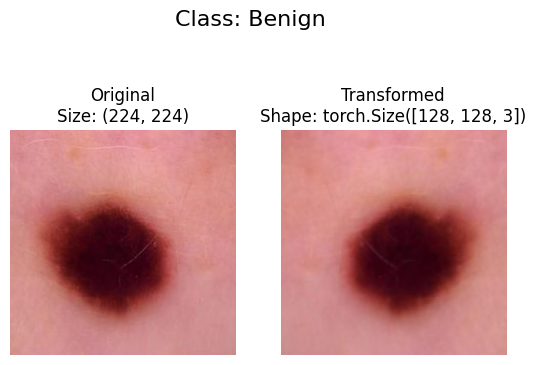

In [1451]:
def plot_transformed_images(image_paths, transform, n=3):
    rand_image_paths = random.sample(image_paths, k=n)
    for image_path in rand_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
    
plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3)

In [1452]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 200
     Root location: data/melanoma/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 200
     Root location: data/melanoma/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [1453]:
classes = train_data.classes
classes

['Benign', 'Malignant']

In [1454]:
class_dict = train_data.class_to_idx
class_dict

{'Benign': 0, 'Malignant': 1}

In [1455]:
len(train_data), len(test_data)

(200, 200)

In [1456]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

Target dir: data/melanoma/train


['Benign', 'Malignant']

In [1457]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Counld not find the classes. Check the directory: {directory}")
    
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

print(find_classes(train_dir))

(['Benign', 'Malignant'], {'Benign': 0, 'Malignant': 1})


In [1458]:
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None):
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [1459]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=50),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()
])

In [1460]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)


train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ff14f39fe80>,
 <__main__.ImageFolderCustom at 0x7ff14f39dab0>)

In [1461]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True):
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(20,20))
    for i, targ_smaple in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_smaple][0], dataset[targ_smaple][1] 
        targ_image_adjust = targ_image.permute(1,2,0)
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes: 
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

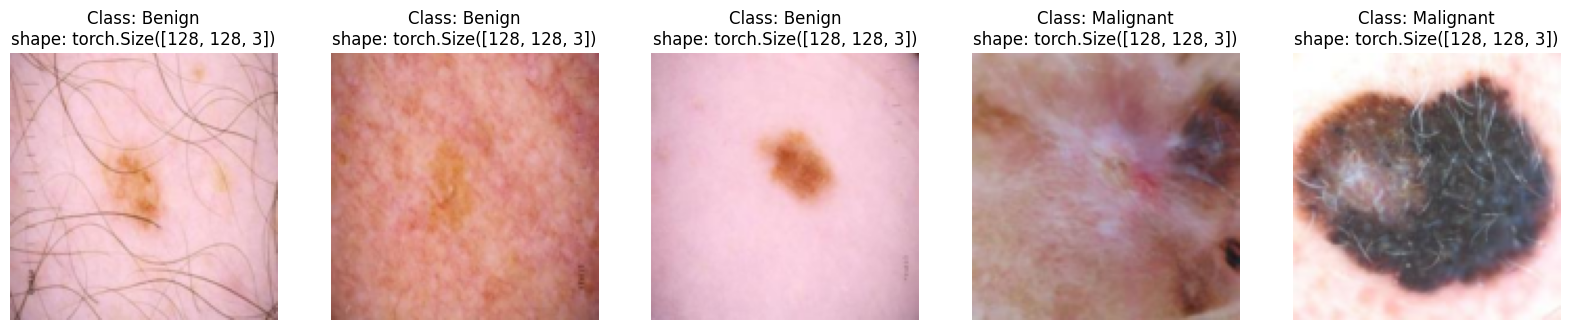

In [1462]:
display_random_images(train_data,
                      n=5,
                      classes=train_data.classes)

In [1463]:
BATCH_SIZE=32
NUM_WORKERS = os.cpu_count()
train_data_loader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

test_data_loader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

In [1464]:
img_custom, label_custom = next(iter(train_data_loader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [1465]:
image_path_list

[PosixPath('data/melanoma/train/Benign/1250.jpg'),
 PosixPath('data/melanoma/train/Benign/1707.jpg'),
 PosixPath('data/melanoma/train/Benign/2719.jpg'),
 PosixPath('data/melanoma/train/Benign/3983.jpg'),
 PosixPath('data/melanoma/train/Benign/3968.jpg'),
 PosixPath('data/melanoma/train/Benign/1229.jpg'),
 PosixPath('data/melanoma/train/Benign/3351.jpg'),
 PosixPath('data/melanoma/train/Benign/3447.jpg'),
 PosixPath('data/melanoma/train/Benign/2461.jpg'),
 PosixPath('data/melanoma/train/Benign/2545.jpg'),
 PosixPath('data/melanoma/train/Benign/1696.jpg'),
 PosixPath('data/melanoma/train/Benign/5301.jpg'),
 PosixPath('data/melanoma/train/Benign/1061.jpg'),
 PosixPath('data/melanoma/train/Benign/5076.jpg'),
 PosixPath('data/melanoma/train/Benign/4328.jpg'),
 PosixPath('data/melanoma/train/Benign/4941.jpg'),
 PosixPath('data/melanoma/train/Benign/4752.jpg'),
 PosixPath('data/melanoma/train/Benign/2757.jpg'),
 PosixPath('data/melanoma/train/Benign/4440.jpg'),
 PosixPath('data/melanoma/train

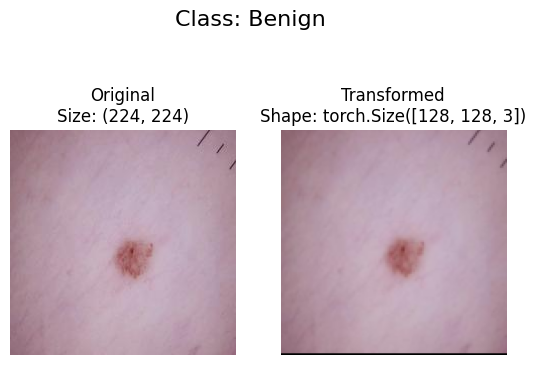

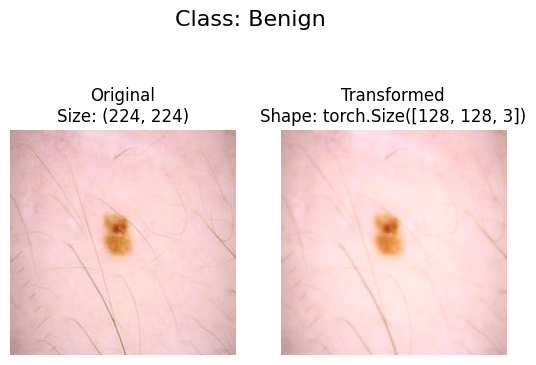

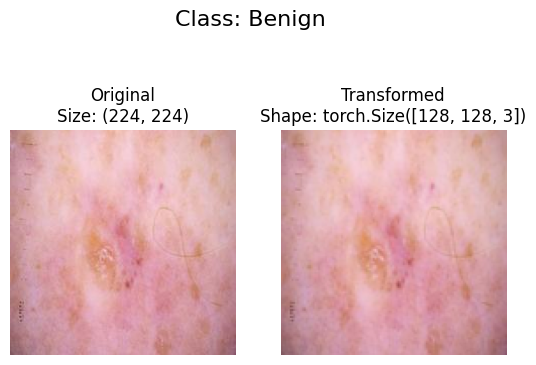

In [1466]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3)

In [1467]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                          out_channels=hidden_units,
                          kernel_size=3,
                          stride=1,
                          padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                          out_channels=hidden_units,
                          kernel_size=3,
                          stride=1,
                          padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                          out_channels=hidden_units,
                          kernel_size=3,
                          stride=1,
                          padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                          out_channels=hidden_units,
                          kernel_size=3,
                          stride=1,
                          padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*841,
                      out_features=output_shape)
        )

    def forward(self, x):
        #x = self.conv_block_1(x)
        #print(x.shape)
        #x = self.conv_block_2(x)
        #print(x.shape)
        #out = self.classifier(x)
        #print(x.shape)
        #return out
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))
        

In [1468]:
model = TinyVGG(input_shape=3,
                  hidden_units=16,
                  output_shape=len(class_names_found)).to(device)

In [1469]:
def train_step(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device=device):
    
    model.train()

    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred =torch.round(torch.sigmoid(model(X)))
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item()/len(y_pred))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [1470]:
def test_step(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          device=device):
    
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = torch.round(torch.sigmoid(model(X_test)))
            loss = loss_fn(test_pred, y_test)
            test_loss += loss.item()
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += ((test_pred == y_test).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc


In [1471]:
def trainer_model(model: torch.nn.Module,
            train_dataloader: torch.utils.data.DataLoader,
            test_dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            epochs: int = 5,
            device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    

In [1472]:
LEARNING_RATE = 0.01
EPOCHS = 10
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [1473]:
start_time = timer()
model_results = trainer_model(model=model,
                        train_dataloader=train_data_loader_custom,
                        test_dataloader=test_data_loader_custom,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=EPOCHS,
                        device=device)
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:01<?, ?it/s]


ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 2]))